In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing

%matplotlib inline

In [237]:
attacks = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/wadi_attacks.csv", sep=",", skiprows=[0])

In [238]:
attacks = preprocessing.normalize(attacks.to_numpy()[:, 1:], norm="max", axis=0)

# # swap sport to front
# attacks[:, [0, 1]] = attacks[:, [1, 0]]
# # swap dport to after sport
# attacks[:, [1, 2]] = attacks[:, [2, 1]]
# # swap protocols to after dport
# attacks[:, [2, 14]] = attacks[:, [14, 2]]

# column order now -> sport, dport, protocols, continuous (discrete, discrete, discrete, continuous)



# should probably add batch and shuffle

train_dataset = attacks#[:int(np.floor(attacks.shape[0]*3/4))]
test_dataset = attacks[-5000:]

num_features = attacks[:int(np.floor(attacks.shape[0]*3/4))].shape[1]
seq_length = 10

In [239]:
len(train_dataset), len(test_dataset)

(9976, 5000)

In [5]:
train_dataset[2]

array([2.71767327e-01, 7.66154879e-03, 8.27653359e-03, 8.00000000e-01,
       7.60913096e-03, 3.76573184e-03, 8.50432283e-03, 6.94274362e-05,
       1.53165877e-05, 1.53165877e-05, 1.53165870e-05, 1.53165870e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.77274300e-02,
       8.43319240e-03, 9.59523343e-01, 9.99938846e-01, 9.59523343e-01,
       9.59523343e-01, 9.59523343e-01, 3.33333333e-01, 3.85114806e-02,
       2.97226418e-05, 9.59523343e-01, 2.77274300e-02])

In [6]:
train_dataset[3]

array([4.75905637e-01, 7.66154879e-03, 8.27653359e-03, 4.00000000e-01,
       4.50540649e-03, 2.22970964e-03, 4.99717308e-03, 4.07958307e-05,
       1.50599124e-05, 1.50599124e-05, 1.51733500e-05, 1.51733500e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.83647165e-02,
       7.88910350e-03, 5.68234365e-01, 9.99939177e-01, 5.68234365e-01,
       5.68234365e-01, 5.68234365e-01, 8.90196078e-01, 2.28028504e-02,
       1.75989326e-05, 5.68234365e-01, 1.83647165e-02])

In [7]:
# custom loss
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(y_true * y_pred)

In [8]:
# clip model weights to a given hypercube
class ClipConstraint(tf.keras.constraints.Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return tf.keras.backend.clip(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [9]:
# Wasserstein loss for critic
def critic_loss(pred_real, pred_fake):
    return tf.keras.backend.mean(pred_real * pred_fake)

# Wasserstein loss for generator
def generator_loss(pred_fake):
    return -tf.keras.backend.mean(pred_fake)

In [10]:
generator_optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00005)
critic_optimiser = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.00005)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [240]:
import torch
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, _data, num_classes_list):
        self.data = torch.tensor(_data, dtype=torch.float32)
        self.num_classes_list = num_classes_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # One-hot encode each of the first three values with different num_classes
        # one_hot_encoded_1 = torch.nn.functional.one_hot(sample[0].long(), self.num_classes_list[0])
        # one_hot_encoded_2 = torch.nn.functional.one_hot(sample[1].long(), self.num_classes_list[1])
        # one_hot_encoded_3 = torch.nn.functional.one_hot(sample[2].long(), self.num_classes_list[2])
        # modified_sample = torch.cat((one_hot_encoded_1.float(), one_hot_encoded_2.float(), one_hot_encoded_3.float(), sample[3:]))

        # WADI
        one_hot_encoded_1 = torch.nn.functional.one_hot(sample[0].long(), self.num_classes_list[0])
        modified_sample = torch.cat((one_hot_encoded_1.float(), sample[1:]))

        # print("1 :",one_hot_encoded_1.shape)
        # print("2 :",one_hot_encoded_2.shape)
        # print("3 :",one_hot_encoded_3.shape)
        # print("4 :",sample[3:].shape)
        # Concatenate one-hot encoding with the remaining values
        

        return modified_sample

data = np.array(train_dataset[:10000])

# SWaT
# dataset = Dataset(data,[23030, 14372, 7])

# WUSTL
# dataset = Dataset(data,[44536, 7756, 4])

# WADI
dataset = Dataset(data,[3, 1, 1])

# SWaT sensor
# dataset = Dataset(data,[3, 2, 12])

batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)


In [12]:
def differentiable_argmax(gumbel_softmax_sample):
    _, max_indices = gumbel_softmax_sample.max(dim=-1, keepdim=True)
    one_hot = torch.zeros_like(gumbel_softmax_sample).scatter_(-1, max_indices, 1.0)
    return one_hot - gumbel_softmax_sample.detach() + gumbel_softmax_sample

In [13]:
def convert_generator_output(output_tensors):
    sport_dist, dport_dist, proto_dist, cont = output_tensors
    num_samples = sport_dist.size(0)
    final = torch.zeros((num_samples, 22))

    for sample_index in range(num_samples):
        sport = torch.argmax(sport_dist[sample_index]) + 1
        dport = torch.argmax(dport_dist[sample_index]) + 1
        proto = torch.argmax(proto_dist[sample_index]) + 1

        data_point = torch.cat((sport.view(1), dport.view(1), proto.view(1), cont[sample_index]))
        final[sample_index] = data_point

    return final

In [241]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Gumbel
num_features = attacks.shape[1]
# Generator model

class Generator(nn.Module):
    def __init__(self, input_dim, num_features):
        super(Generator, self).__init__()

        self.hidden1 = nn.Linear(input_dim, 8000)
        self.hidden2 = nn.Linear(8000, 80)

        # SWaT
        # self.sport_hidden = nn.Linear(10, 23030)
        # self.dport_hidden = nn.Linear(10, 14372)
        # self.proto_hidden = nn.Linear(10, 7)

        # WUSTL
        # self.sport_hidden = nn.Linear(10, 44536)
        # self.dport_hidden = nn.Linear(10, 7756)
        # self.proto_hidden = nn.Linear(10, 4)

        # WADI
        self.sport_hidden = nn.Linear(10, 3)
        self.dport_hidden = nn.Linear(10, 1)
        self.proto_hidden = nn.Linear(10, 1)

        # SWaT sensor
        # self.sport_hidden = nn.Linear(10, 3)
        # self.dport_hidden = nn.Linear(10, 2)
        # self.proto_hidden = nn.Linear(10, 12)

        # self.sport_output = nn.Softmax(dim=1)
        # self.dport_output = nn.Softmax(dim=1)
        # self.proto_output = nn.Softmax(dim=1)

        self.cont_output = nn.Linear(50, num_features - 3)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        # r = nn.LeakyReLU()
        # x = r(self.hidden1(x))
        # x = r(self.hidden2(x))
        # print(x.shape)

        _sport_hidden = self.sport_hidden(x[:,:10])
        _dport_hidden = self.dport_hidden(x[:,10:20])

        _proto_hidden = self.proto_hidden(x[:,20:30])


        # sport_output = self.sport_output(sport_hidden)
        # dport_output = self.dport_output(dport_hidden)
        # proto_output = self.proto_output(proto_hidden)

        # Do not apply torch.argmax here, let the loss function handle it
        cont_output = self.cont_output(x[:,30:])
        # cont_output = self.cont_output(x)

        # Concatenate the tensors along dimension 1
        output_tensor = torch.cat((_sport_hidden, _dport_hidden, _proto_hidden, cont_output), dim=1)
        return output_tensor
        # return sport_output, dport_output, proto_output, cont_output
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size=100, recurrent_dropout=0.4):
        super(Discriminator, self).__init__()

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True, dropout=recurrent_dropout)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True, dropout=recurrent_dropout)

        # Batch normalization layers
        self.batch_norm1 = nn.BatchNorm1d(hidden_size * 2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size * 2)

        # Linear output layer
        self.output_layer = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):


        # LSTM layers
        out, _ = self.lstm1(x)
        # print(out.shape)
        out = self.batch_norm1(out)
        # print(out.shape)
        out, _ = self.lstm2(out)
        # print(out.shape)
        out = self.batch_norm2(out)
        # print(out.shape)

        # Global average pooling
        # out = torch.mean(out, dim=1)
        # print(out.shape)
        # Output layer
        # out = self.output_layer(out)
        out = torch.sigmoid(self.output_layer(out))


        return out  # Fix for the dimension mismatch

# Hyperparameters
latent_dim = 100
data_dim = len(dataset[1])
lr = 0.00002
batch_size = 64
epochs = 50
discriminator_loops = 1

# Models
generator = Generator(latent_dim, num_features)
discriminator = Discriminator(data_dim)
max_grad_norm = 1.0
# Loss function and optimizers
criterion = nn.BCELoss()
# criterion = nn.HuberLoss()
# criterion_gen = nn.SmoothL1Loss()
criterion_gen = nn.BCELoss()
# criterion_gen = nn.HuberLoss()
# criterion = nn.CrossEntropyLoss()
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Training loop
import csv
import copy
from tqdm import tqdm
parameters_list = []
disc_parameters_list = []
dlosses = []
glosses = []
dlosses_fake = []
dlosses_real = []
gl = []

generator.train()
discriminator.train()
for epoch in tqdm(range(epochs)):
    total_loss_fake = 0
    total_loss_real = 0
    total_loss_gen = 0
    for batch in data_loader:
        # Train Discriminator
        for _ in range(discriminator_loops):
            real_data = batch
            real_labels = torch.ones((batch_size, 1))
            fake_labels = torch.zeros((batch_size, 1))

            optimizer_d.zero_grad()

            # Real data
            # print("Real data: ", real_data.shape)
            output_real = discriminator(real_data)
            # print(output_real)
            loss_real = criterion(output_real, real_labels)
            # print("Loss:", loss_real.item())
            loss_real.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
            optimizer_d.step()
            # print("Gradients of a specific layer:", generator.hidden1.weight.grad)
            total_loss_real+=loss_real

            # Fake data
            noise = torch.randn(batch_size, latent_dim)
            output = generator(noise)

            # SWaT
            # sport_output = F.softmax(output[:, :23030], dim=1)
            # dport_output = F.softmax(output[:, 23030:23030+14372], dim=1)
            # proto_output = F.softmax(output[:, 23030+14372:23030+14372+7], dim=1)
            # cont_output = output[:, 23030+14372+7:]

            # WUSTL
            # sport_output = F.softmax(output[:, :44536], dim=1)
            # dport_output = F.softmax(output[:, 44536:44536+7756], dim=1)
            # proto_output = F.softmax(output[:, 44536+7756:44536+7756+4], dim=1)
            # cont_output = output[:, 44536+7756+4:]

            # WADI
            sport_output = F.softmax(output[:, :3], dim=1)
            dport_output = F.softmax(output[:, 3:3+1], dim=1)
            proto_output = F.softmax(output[:, 3+1:3+1+1], dim=1)
            cont_output = output[:, 3+1+1:]

            # SWaT sensor
            # sport_output = F.softmax(output[:, :3], dim=1)
            # dport_output = F.softmax(output[:, 3:3+2], dim=1)
            # proto_output = F.softmax(output[:, 3+2:3+2+12], dim=1)
            # cont_output = output[:, 3+2+12:]

            fake_data = torch.cat((sport_output, dport_output, proto_output, cont_output), dim=1)

            output_fake = discriminator(fake_data)
            # print(output_fake)
            # print(fake_labels)
            loss_fake = criterion(output_fake, fake_labels)
            loss_fake.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
            total_loss_fake+=loss_fake
            # print("Gradients of a specific layer:", generator.hidden1.weight.grad)
            optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        # generated_data = generator(noise)
        output = generator(noise)
        # print(fake_data.shape)

        # SWaT
        # sport_output = F.softmax(output[:, :23030], dim=1)
        # dport_output = F.softmax(output[:, 23030:23030+14372], dim=1)
        # proto_output = F.softmax(output[:, 23030+14372:23030+14372+7], dim=1)
        # cont_output = output[:, 23030+14372+7:]

        # WUSTL
        # sport_output = F.softmax(output[:, :44536], dim=1)
        # dport_output = F.softmax(output[:, 44536:44536+7756], dim=1)
        # proto_output = F.softmax(output[:, 44536+7756:44536+7756+4], dim=1)
        # cont_output = output[:, 44536+7756+4:]

        # WADI
        sport_output = F.softmax(output[:, :3], dim=1)
        dport_output = F.softmax(output[:, 3:3+1], dim=1)
        proto_output = F.softmax(output[:, 3+1:3+1+1], dim=1)
        cont_output = output[:, 3+1+1:]

        # SWaT sensor
        # sport_output = F.softmax(output[:, :3], dim=1)
        # dport_output = F.softmax(output[:, 3:3+2], dim=1)
        # proto_output = F.softmax(output[:, 3+2:3+2+12], dim=1)
        # cont_output = output[:, 3+2+12:]


        # temperature = 1.0  # You can adjust the temperature hyperparameter
        # gumbel_dist = Gumbel(0, 1).sample(sport_hidden.shape)
        # sport_output = F.softmax((sport_hidden + gumbel_dist) / temperature, dim=1)

        # gumbel_dist = Gumbel(0, 1).sample(dport_hidden.shape)
        # dport_output = F.softmax((dport_hidden + gumbel_dist) / temperature, dim=1)

        # gumbel_dist = Gumbel(0, 1).sample(proto_hidden.shape)
        # proto_output = F.softmax((proto_hidden + gumbel_dist) / temperature, dim=1)

        # generated_data = torch.cat((differentiable_argmax(sport_output).unsqueeze(1),differentiable_argmax(dport_output)[:,1].unsqueeze(1),differentiable_argmax(proto_output)[:,1].unsqueeze(1), cont_output), dim=1)
        # generated_data = torch.cat((sport_output[:,1].unsqueeze(1),dport_output[:,2].unsqueeze(1),proto_output[:,3].unsqueeze(1),cont_output), dim=1)
        generated_data = torch.cat((sport_output, dport_output, proto_output, cont_output), dim=1)
        # print(generated_data.shape)


        # generated_data = convert_generator_output(generator(noise))
        # print(generated_data.shape)
        output_generated = discriminator(generated_data)
        # loss_gen = criterion(output_generated, real_labels)
        loss_gen = criterion_gen(output_generated, real_labels.float())
        # print("Discriminator Output:", output_generated)
        # print("Real Labels:", real_labels)
        # print("Loss:", loss_gen.item())
        loss_gen.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
        # torch.nn.utils.clip_grad_norm_([generator.sport_hidden.weight], max_grad_norm)
        total_loss_gen+=loss_gen
        # for param in generator.sport_hidden.parameters():
        #   print(param.requires_grad)
        # for name, param in generator.named_parameters():
        #   if name == 'sport_hidden.weight':
        #       print(name, param.requires_grad)
        #       print(name, param.grad)
        #       print(f"{name} - Gradient Statistics: Mean={param.grad.mean()}, Std={param.grad.std()}, Min={param.grad.min()}, Max={param.grad.max()}")

        # asdasdasd
        # print("Gradients of a specific layer:", generator.sport_hidden.weight.grad)
        optimizer_g.step()

    # Print losses at the end of each epoch
    print(f"Epoch [{epoch+1}/{epochs}], D Loss Real: {total_loss_real}, D Loss Fake: {total_loss_fake}, G Loss: {total_loss_gen}")
    # print(f"\nEpoch {epoch + 1} - Parameters of Generator:\n")
    epoch_parameters = {"Epoch": epoch + 1}
    # epoch_parameters = {}
    for name, param in generator.named_parameters():
        # print(name, param.data)
        # Store parameters in the dictionary
        # epoch_parameters["Epoch"] = epoch + 1
        # epoch_parameters[name] = param.data
        epoch_parameters[name] = copy.deepcopy(param.data.numpy())

    disc_params = {"Epoch": epoch + 1}
    for name, param in discriminator.named_parameters():
        disc_params[name] = copy.deepcopy(param.data.numpy())

    # Append epoch parameters to the dictionary
    parameters_list.append(epoch_parameters)
    disc_parameters_list.append(disc_params)
    dlosses.append(loss_real + loss_fake)
    glosses.append(loss_gen)

    dlosses_fake.append(total_loss_fake)
    dlosses_real.append(total_loss_real)
    gl.append(total_loss_gen)

/home/knel/virtual_envs/ankh-morpork/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:05<04:44,  5.82s/it]

Epoch [1/50], D Loss Real: 103.42058563232422, D Loss Fake: 115.46044158935547, G Loss: 103.92402648925781


  4%|▍         | 2/50 [00:11<04:35,  5.73s/it]

Epoch [2/50], D Loss Real: 100.26966857910156, D Loss Fake: 116.98600769042969, G Loss: 100.61597442626953


  6%|▌         | 3/50 [00:17<04:28,  5.70s/it]

Epoch [3/50], D Loss Real: 97.92295837402344, D Loss Fake: 119.17755126953125, G Loss: 98.15933990478516


  8%|▊         | 4/50 [00:22<04:21,  5.69s/it]

Epoch [4/50], D Loss Real: 95.7152099609375, D Loss Fake: 121.49642944335938, G Loss: 95.85798645019531


 10%|█         | 5/50 [00:28<04:13,  5.63s/it]

Epoch [5/50], D Loss Real: 93.5168685913086, D Loss Fake: 123.92953491210938, G Loss: 93.5820083618164


 12%|█▏        | 6/50 [00:33<04:05,  5.58s/it]

Epoch [6/50], D Loss Real: 91.30438995361328, D Loss Fake: 126.4952621459961, G Loss: 91.27532958984375


 14%|█▍        | 7/50 [00:39<03:58,  5.54s/it]

Epoch [7/50], D Loss Real: 89.08296966552734, D Loss Fake: 129.2926025390625, G Loss: 89.02151489257812


 16%|█▌        | 8/50 [00:44<03:51,  5.51s/it]

Epoch [8/50], D Loss Real: 86.81522369384766, D Loss Fake: 132.17930603027344, G Loss: 86.7231216430664


 18%|█▊        | 9/50 [00:50<03:45,  5.49s/it]

Epoch [9/50], D Loss Real: 84.58343505859375, D Loss Fake: 135.16934204101562, G Loss: 84.47711181640625


 20%|██        | 10/50 [00:55<03:37,  5.44s/it]

Epoch [10/50], D Loss Real: 82.43730163574219, D Loss Fake: 138.16749572753906, G Loss: 82.29988861083984


 22%|██▏       | 11/50 [01:01<03:33,  5.46s/it]

Epoch [11/50], D Loss Real: 80.3794174194336, D Loss Fake: 141.10067749023438, G Loss: 80.20792388916016


 24%|██▍       | 12/50 [01:06<03:28,  5.49s/it]

Epoch [12/50], D Loss Real: 78.46697998046875, D Loss Fake: 143.9486083984375, G Loss: 78.27981567382812


 26%|██▌       | 13/50 [01:11<03:20,  5.43s/it]

Epoch [13/50], D Loss Real: 76.68138885498047, D Loss Fake: 146.63504028320312, G Loss: 76.4937515258789


 28%|██▊       | 14/50 [01:17<03:15,  5.43s/it]

Epoch [14/50], D Loss Real: 75.0904312133789, D Loss Fake: 149.15162658691406, G Loss: 74.88323974609375


 30%|███       | 15/50 [01:22<03:08,  5.38s/it]

Epoch [15/50], D Loss Real: 73.6471939086914, D Loss Fake: 151.457275390625, G Loss: 73.43003845214844


 32%|███▏      | 16/50 [01:27<03:02,  5.36s/it]

Epoch [16/50], D Loss Real: 72.3617935180664, D Loss Fake: 153.5712432861328, G Loss: 72.15202331542969


 34%|███▍      | 17/50 [01:33<02:57,  5.37s/it]

Epoch [17/50], D Loss Real: 71.22412109375, D Loss Fake: 155.4761505126953, G Loss: 71.01937103271484


 36%|███▌      | 18/50 [01:38<02:50,  5.33s/it]

Epoch [18/50], D Loss Real: 70.21270751953125, D Loss Fake: 157.18026733398438, G Loss: 70.0208740234375


 38%|███▊      | 19/50 [01:43<02:44,  5.31s/it]

Epoch [19/50], D Loss Real: 69.33747100830078, D Loss Fake: 158.70480346679688, G Loss: 69.14029693603516


 40%|████      | 20/50 [01:48<02:37,  5.24s/it]

Epoch [20/50], D Loss Real: 68.5791244506836, D Loss Fake: 160.05587768554688, G Loss: 68.37584686279297


 42%|████▏     | 21/50 [01:54<02:31,  5.24s/it]

Epoch [21/50], D Loss Real: 67.8783187866211, D Loss Fake: 161.2581024169922, G Loss: 67.71060943603516


 44%|████▍     | 22/50 [01:59<02:24,  5.18s/it]

Epoch [22/50], D Loss Real: 67.3004150390625, D Loss Fake: 162.31175231933594, G Loss: 67.12065124511719


 46%|████▌     | 23/50 [02:04<02:18,  5.15s/it]

Epoch [23/50], D Loss Real: 66.7925033569336, D Loss Fake: 163.2418670654297, G Loss: 66.61148071289062


 48%|████▊     | 24/50 [02:09<02:13,  5.14s/it]

Epoch [24/50], D Loss Real: 66.33729553222656, D Loss Fake: 164.05996704101562, G Loss: 66.16412353515625


 50%|█████     | 25/50 [02:14<02:08,  5.13s/it]

Epoch [25/50], D Loss Real: 65.93671417236328, D Loss Fake: 164.78269958496094, G Loss: 65.7736587524414


 52%|█████▏    | 26/50 [02:19<02:02,  5.11s/it]

Epoch [26/50], D Loss Real: 65.59295654296875, D Loss Fake: 165.41598510742188, G Loss: 65.43317413330078


 54%|█████▍    | 27/50 [02:24<01:56,  5.05s/it]

Epoch [27/50], D Loss Real: 65.2842788696289, D Loss Fake: 165.976806640625, G Loss: 65.13864135742188


 56%|█████▌    | 28/50 [02:29<01:49,  4.99s/it]

Epoch [28/50], D Loss Real: 65.02287292480469, D Loss Fake: 166.46923828125, G Loss: 64.87987518310547


 58%|█████▊    | 29/50 [02:34<01:44,  4.97s/it]

Epoch [29/50], D Loss Real: 64.78330993652344, D Loss Fake: 166.8948974609375, G Loss: 64.64779663085938


 60%|██████    | 30/50 [02:38<01:38,  4.93s/it]

Epoch [30/50], D Loss Real: 64.58702850341797, D Loss Fake: 167.2739715576172, G Loss: 64.4481201171875


 62%|██████▏   | 31/50 [02:44<01:34,  4.96s/it]

Epoch [31/50], D Loss Real: 64.40025329589844, D Loss Fake: 167.6094207763672, G Loss: 64.2759780883789


 64%|██████▍   | 32/50 [02:48<01:29,  4.95s/it]

Epoch [32/50], D Loss Real: 64.2323226928711, D Loss Fake: 167.89942932128906, G Loss: 64.11643981933594


 66%|██████▌   | 33/50 [02:53<01:23,  4.91s/it]

Epoch [33/50], D Loss Real: 64.09893035888672, D Loss Fake: 168.16053771972656, G Loss: 63.982242584228516


 68%|██████▊   | 34/50 [02:58<01:18,  4.89s/it]

Epoch [34/50], D Loss Real: 63.97647476196289, D Loss Fake: 168.3870391845703, G Loss: 63.86531066894531


 70%|███████   | 35/50 [03:03<01:12,  4.86s/it]

Epoch [35/50], D Loss Real: 63.86104965209961, D Loss Fake: 168.58534240722656, G Loss: 63.75811004638672


 72%|███████▏  | 36/50 [03:08<01:08,  4.87s/it]

Epoch [36/50], D Loss Real: 63.76409912109375, D Loss Fake: 168.7657928466797, G Loss: 63.6674919128418


 74%|███████▍  | 37/50 [03:13<01:02,  4.84s/it]

Epoch [37/50], D Loss Real: 63.67943572998047, D Loss Fake: 168.92088317871094, G Loss: 63.584373474121094


 76%|███████▌  | 38/50 [03:17<00:58,  4.84s/it]

Epoch [38/50], D Loss Real: 63.60956573486328, D Loss Fake: 169.05816650390625, G Loss: 63.513893127441406


 78%|███████▊  | 39/50 [03:22<00:53,  4.85s/it]

Epoch [39/50], D Loss Real: 63.537418365478516, D Loss Fake: 169.17794799804688, G Loss: 63.44990158081055


 80%|████████  | 40/50 [03:27<00:48,  4.84s/it]

Epoch [40/50], D Loss Real: 63.48252487182617, D Loss Fake: 169.2830047607422, G Loss: 63.39293670654297


 82%|████████▏ | 41/50 [03:32<00:43,  4.80s/it]

Epoch [41/50], D Loss Real: 63.42539596557617, D Loss Fake: 169.37750244140625, G Loss: 63.34262466430664


 84%|████████▍ | 42/50 [03:37<00:38,  4.77s/it]

Epoch [42/50], D Loss Real: 63.37322998046875, D Loss Fake: 169.46583557128906, G Loss: 63.300926208496094


 86%|████████▌ | 43/50 [03:41<00:33,  4.76s/it]

Epoch [43/50], D Loss Real: 63.339595794677734, D Loss Fake: 169.53900146484375, G Loss: 63.260498046875


 88%|████████▊ | 44/50 [03:46<00:28,  4.73s/it]

Epoch [44/50], D Loss Real: 63.29937744140625, D Loss Fake: 169.60391235351562, G Loss: 63.22505569458008


 90%|█████████ | 45/50 [03:51<00:23,  4.73s/it]

Epoch [45/50], D Loss Real: 63.26213073730469, D Loss Fake: 169.66358947753906, G Loss: 63.19425582885742


 92%|█████████▏| 46/50 [03:55<00:18,  4.72s/it]

Epoch [46/50], D Loss Real: 63.23274230957031, D Loss Fake: 169.7146759033203, G Loss: 63.16436767578125


 94%|█████████▍| 47/50 [04:00<00:14,  4.75s/it]

Epoch [47/50], D Loss Real: 63.201744079589844, D Loss Fake: 169.7618865966797, G Loss: 63.13963317871094


 96%|█████████▌| 48/50 [04:05<00:09,  4.75s/it]

Epoch [48/50], D Loss Real: 63.17633819580078, D Loss Fake: 169.803955078125, G Loss: 63.1156120300293


 98%|█████████▊| 49/50 [04:10<00:04,  4.73s/it]

Epoch [49/50], D Loss Real: 63.154727935791016, D Loss Fake: 169.8432159423828, G Loss: 63.09642028808594


100%|██████████| 50/50 [04:14<00:00,  5.10s/it]

Epoch [50/50], D Loss Real: 63.1355094909668, D Loss Fake: 169.8780975341797, G Loss: 63.07865524291992


In [223]:
# import csv

# with open('params.csv','w') as f:
#     w = csv.writer(f)
#     for epoch in parameters_list:
#         w.writerows(epoch.items())

# with open('disc_params.csv', 'w') as f:
#     w = csv.writer(f)
#     for epoch in disc_parameters_list:
#         w.writerows(epoch.items())

In [242]:
dl_real = [var.detach().numpy() for var in dlosses_real]
dl_fake = [var.detach().numpy() for var in dlosses_fake]
dl_total = np.asarray(dl_real) + np.asarray(dl_fake)
gls = [var.detach().numpy() for var in gl]

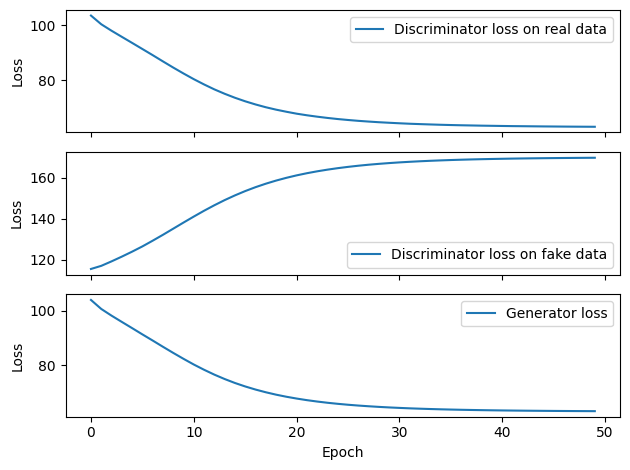

In [245]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, layout="tight")
# f.tight_layout()
ax1.plot(dl_real, label="Discriminator loss on real data")
ax2.plot(dl_fake, label="Discriminator loss on fake data")
ax3.plot(gls,label="Generator loss")
ax3.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Loss")
ax3.set_ylabel("Loss")
ax1.legend()
ax2.legend(loc="lower right")
ax3.legend()
# f.savefig("gan_softmax_wadi_50.png")

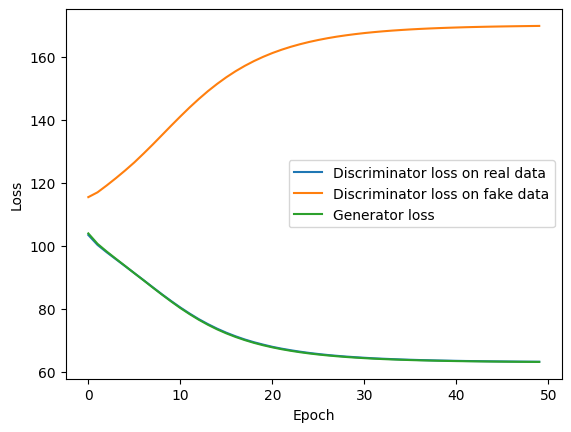

In [244]:
plt.plot(dl_real, label="Discriminator loss on real data")
plt.plot(dl_fake, label="Discriminator loss on fake data")
plt.plot(gls, label="Generator loss")
# plt.plot(dl_total)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

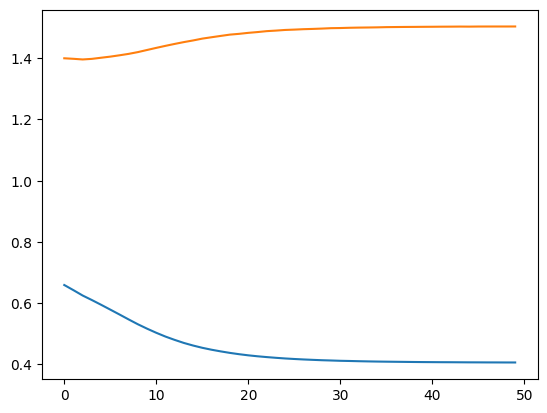

In [228]:
dl = [dloss.detach().numpy() for dloss in dlosses]
gl = [gloss.detach().numpy() for gloss in glosses]
plt.plot(gl)
plt.plot(dl)

In [ ]:
# csv_file_path = "generator_parameters_1.csv"
# with open(csv_file_path, mode='w', newline='') as csv_file:
#     fieldnames = ["Epoch"] + list(generator.state_dict().keys())
#     csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
#     print(fieldnames)
#     # Write the header
#     csv_writer.writeheader()

#     # Write parameters for each epoch
#     for i in parameters_list:
#       # print(i)
#       # for key in i.keys():
#       # print(i.values())
#       print(i.keys())
#       row = {}
#       for key in i.keys():
#         row[key] = i[key]
#       print(row.keys())
#       csv_writer.writerow(i)

#       # exit
#       # csv_writer.writerows(i.values())

In [69]:
def convert_softmax_output_swat(tens):

    output = np.asarray([var.detach().numpy() for var in tens])

    sport = output[:, :23030]
    dport = output[:, 23030:23030+14372]
    proto = output[:, 23030+14372:23030+14372+7]
    cont = output[:, 23030+14372+7:]

    num_samples = sport.shape[0]

    sport_select = np.argmax(sport, axis=1)
    dport_select = np.argmax(dport, axis=1)
    proto_select = np.argmax(proto, axis=1)

    return np.hstack((sport_select.reshape(num_samples, 1), dport_select.reshape(num_samples, 1), proto_select.reshape(num_samples, 1), cont))

def convert_softmax_output_wustl(tens):

    output = np.asarray([var.detach().numpy() for var in tens])

    sport = output[:, :44536]
    dport = output[:, 44536:44536+7756]
    proto = output[:, 44536+7756:44536+7756+4]
    cont = output[:, 44536+7756+4:]

    num_samples = sport.shape[0]

    sport_select = np.argmax(sport, axis=1)
    dport_select = np.argmax(dport, axis=1)
    proto_select = np.argmax(proto, axis=1)

    return np.hstack((sport_select.reshape(num_samples, 1), dport_select.reshape(num_samples, 1), proto_select.reshape(num_samples, 1), cont))

def convert_softmax_output_wadi(tens):

    output = np.asarray([var.detach().numpy() for var in tens])

    sport = output[:, :3]
    dport = output[:, 3:3+1]
    proto = output[:, 3+1:3+1+1]
    cont = output[:, 3+1+1:]

    num_samples = sport.shape[0]

    sport_select = np.argmax(sport, axis=1)
    dport_select = np.argmax(dport, axis=1)
    proto_select = np.argmax(proto, axis=1)

    return np.hstack((sport_select.reshape(num_samples, 1), dport_select.reshape(num_samples, 1), proto_select.reshape(num_samples, 1), cont))

def convert_softmax_output_swat_sensor(tens):

    output = np.asarray([var.detach().numpy() for var in tens])

    sport = output[:, :3]
    dport = output[:, 3:3+2]
    proto = output[:, 3+2:3+2+12]
    cont = output[:, 3+2+12:]

    num_samples = sport.shape[0]

    sport_select = np.argmax(sport, axis=1)
    dport_select = np.argmax(dport, axis=1)
    proto_select = np.argmax(proto, axis=1)

    return np.hstack((sport_select.reshape(num_samples, 1), dport_select.reshape(num_samples, 1), proto_select.reshape(num_samples, 1), cont))

In [229]:
import scipy
test_noise = torch.randn(test_dataset.shape[0], latent_dim)
preds = generator(test_noise)
data = convert_softmax_output_swat_sensor(preds)
scipy.stats.ks_2samp(test_dataset.reshape(preds.shape[0]*num_features,), data.reshape(preds.shape[0]*num_features,))

KstestResult(statistic=0.7934857142857143, pvalue=0.0, statistic_location=0.37703365087509155, statistic_sign=-1)

In [208]:
# df = pd.DataFrame(data)
# df.to_csv("gan_softmax_swat_50.csv", index=False)